# Laboratorium 1
Kamil Patan

## Wstęp
Skrypt jest utworzony dla 1 wariantu ze stałym krokiem metodą RUngego-Kutty 4 rzędu. Użyto go do modelowania dynamiki czterech cząsteczek biologicznych: P53, MDM2 (cytoplazmatycznego i jądrowego) oraz PTEN.

## Opis
Zastosowany wariant:
Wariant 1 - RK4 ze stałym krokiem
Każdy scenariusz odpowiadan innym warunkom biologicznym (np. obecność siRNA, aktywność PTEN, uszkodzenie DNA).
Symulacja przebiega przez 48 godzin z krokiem czasowym dt = 6 minut (czyli 480 kroków).
Wejście/Wyjście:
Brak pliku wejściowego – dane i parametry scenariuszy są zapisane bezpośrednio w kodzie.
Wyniki zapisywane są w katalogu fixed/ w formacie PNG:
    16 wykresów indywidualnych (dla każdej zmiennej i scenariusza),
    4 zbiorcze wykresy (wszystkie zmienne w danym scenariuszu).

## Skrypt

In [1]:
"""
  RK4 ze stałym krokiem

Scenariusze:
  A) podstawowy  (siRNA=False, PTEN_off=False, no_DNA_damage=True)
  B) uszkodzenie (siRNA=False, PTEN_off=False, no_DNA_damage=False)
  C) nowotwór    (siRNA=False, PTEN_off=True, no_DNA_damage=False)
  D) terapia     (siRNA=True, PTEN_off=False, no_DNA_damage=False)

Wynik:
  - Katalog "fixed/"
  - Pliki PNG:
    - 16 indywidualnych: <scenariusz>_<zmienna>.png (P53, MDM2_cyt, MDM2_nuc, PTEN dla każdego scenariusza)
    - 4 połączone: <scenariusz>.png (wszystkie zmienne w jednym wykresie dla każdego scenariusza)
"""

import os
import numpy as np
import matplotlib.pyplot as plt

# Parametry modelu
# Szybkości produkcji
p1 = 8.8    # produkcja P53
p2 = 440    # produkcja MDM2
p3 = 100    # produkcja PTEN
# Szybkości degradacji
d1 = 1.375e-14  # degradacja P53
d2 = 1.375e-4   # degradacja MDM2
d3 = 3e-5   # degradacja PTEN
# Stałe oddziaływań
k1 = 1.925e-4
k2 = 1e5
k3 = 1.5e5

value_siRNA = 0.02
value_PTEN_off = 0
value_no_DNA_damage = 0.1

# Parametry numeryczne zabezpieczające
MN_CLAMP = 1e3  # limit dla MDM2_jądro w obliczeniu potęgi
MIN_DEN = 1e-3  # minimalny mianownik w transporcie (PTEN^2 + k3^2)

# Funkcja obliczająca pochodne
def derivatives(state, siRNA=False, pten_off=False, no_DNA_damage=False):
    P53, MC, MN, PT = state
    # P53
    dP53 = p1 - d1 * P53 * (min(MN, MN_CLAMP)**2)
    # MDMcyto
    siRNA_factor = value_siRNA if siRNA else 1
    DNA_damage_factor = value_no_DNA_damage if no_DNA_damage else 1
    sat = (P53**4) / ((P53**4) + (k2**4)) if P53 > 0 else 0
    denom = max((k3**2) + (PT**2), MIN_DEN)
    trans = k1 * (k3**2) / denom * MC
    dMC = p2 * siRNA_factor * sat - trans - d2 * DNA_damage_factor * MC
    # MDMn
    dMN = trans - d2 * (value_no_DNA_damage if no_DNA_damage else 1) * MN
    # PTEN
    p3_eff = value_PTEN_off if pten_off else 1
    dPT = p3 * p3_eff * sat - d3 * PT
    return np.array([dP53, dMC, dMN, dPT])

# Wariant 1: RK4 ze stałym krokiem czasowym
def rk4_fixed(state, dt, siRNA, pten_off, no_DNA_damage):
    k1_ = derivatives(state, siRNA, pten_off, no_DNA_damage)
    k2_ = derivatives(state + 0.5 * dt * k1_, siRNA, pten_off, no_DNA_damage)
    k3_ = derivatives(state + 0.5 * dt * k2_, siRNA, pten_off, no_DNA_damage)
    k4_ = derivatives(state + dt * k3_, siRNA, pten_off, no_DNA_damage)
    return state + (dt / 6.0) * (k1_ + 2*k2_ + 2*k3_ + k4_)

# Funkcja symulacji ze stałym krokiem
def simulate_fixed(scenarios, dt=6, t_end=48*60):
    t = np.arange(0, t_end + dt, dt)
    results = {}
    for name, cfg in scenarios.items():
        sol = np.zeros((len(t), 4))
        sol[0] = np.array([10, 2000, 10000, 2000])
        for i in range(1, len(t)):
            sol[i] = rk4_fixed(sol[i-1], dt, cfg['siRNA'], cfg['pten_off'], cfg['no_DNA_damage'])
            sol[i] = np.maximum(sol[i], 0.0)
        results[name] = (t / 60, sol)
    return results

# Rysowanie i zapis wyników do PNG
def plot_results(results, folder):
    os.makedirs(folder, exist_ok=True)
    vars = ['P53', 'MDM2_cyt', 'MDM2_nuc', 'PTEN']
    
    # 16 indywidualnych wykresów (po jednym dla każdej zmiennej w każdym scenariuszu)
    for name, (t, sol) in results.items():
        for i, var in enumerate(vars):
            plt.figure()
            plt.plot(t, sol[:, i], linewidth=1)
            plt.xlabel('Czas [h]')
            plt.ylabel('Stężenie [nM]')
            plt.title(f'{var} – scenariusz {name}')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'{folder}/{name}_{var}.png', dpi=150)
            plt.close()
    
    # 4 połączone wykresy (wszystkie zmienne w jednym wykresie dla każdego scenariusza)
    for name, (t, sol) in results.items():
        plt.figure(figsize=(10, 5))
        for i, var in enumerate(vars):
            plt.plot(t, sol[:, i], label=var, linewidth=1)
        plt.xlabel('Czas [h]')
        plt.ylabel('Stężenie [nM]')
        plt.title(f'RK4: Stężenia białek w 48h ({name})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{folder}/{name}.png', dpi=150)
        plt.close()

if __name__ == '__main__':
    scenariusze = {
        'A_podstawowy':  {'siRNA': False, 'pten_off': False, 'no_DNA_damage': True},
        'B_uszkodzenie': {'siRNA': False, 'pten_off': False, 'no_DNA_damage': False},
        'C_nowotwor':    {'siRNA': False, 'pten_off': True,  'no_DNA_damage': False},
        'D_terapia':     {'siRNA': True,  'pten_off': False, 'no_DNA_damage': False},
    }
    results = simulate_fixed(scenariusze)
    plot_results(results, 'fixed')
    print('Wygenerowano 20 wykresów w katalogu "fixed".')

Matplotlib is building the font cache; this may take a moment.


Wygenerowano 20 wykresów w katalogu "fixed".


## Wykresy
## Scenariusz A
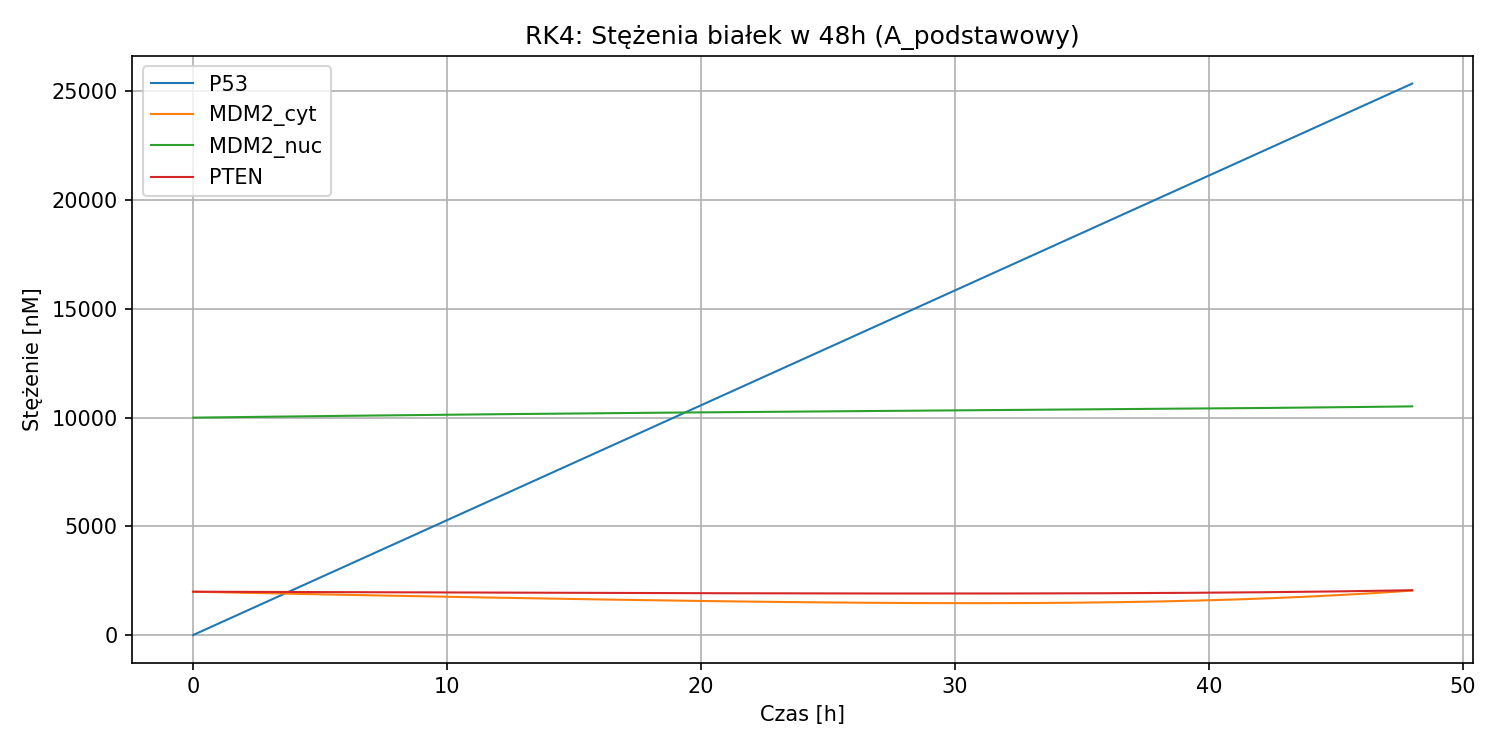
## MDM2_cyt
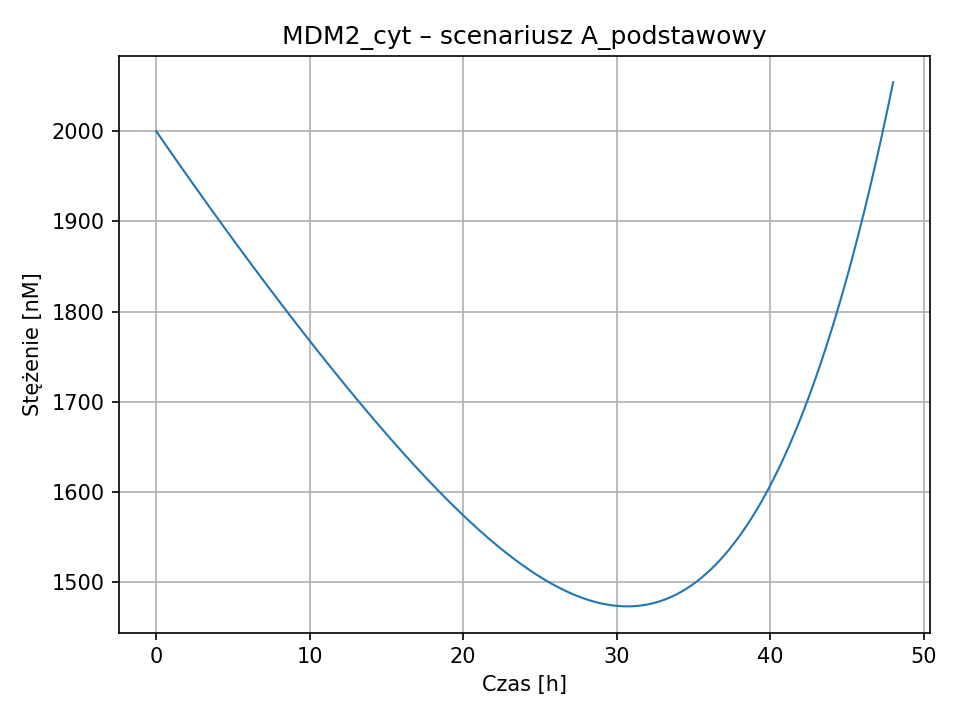
## MDM2_nuc
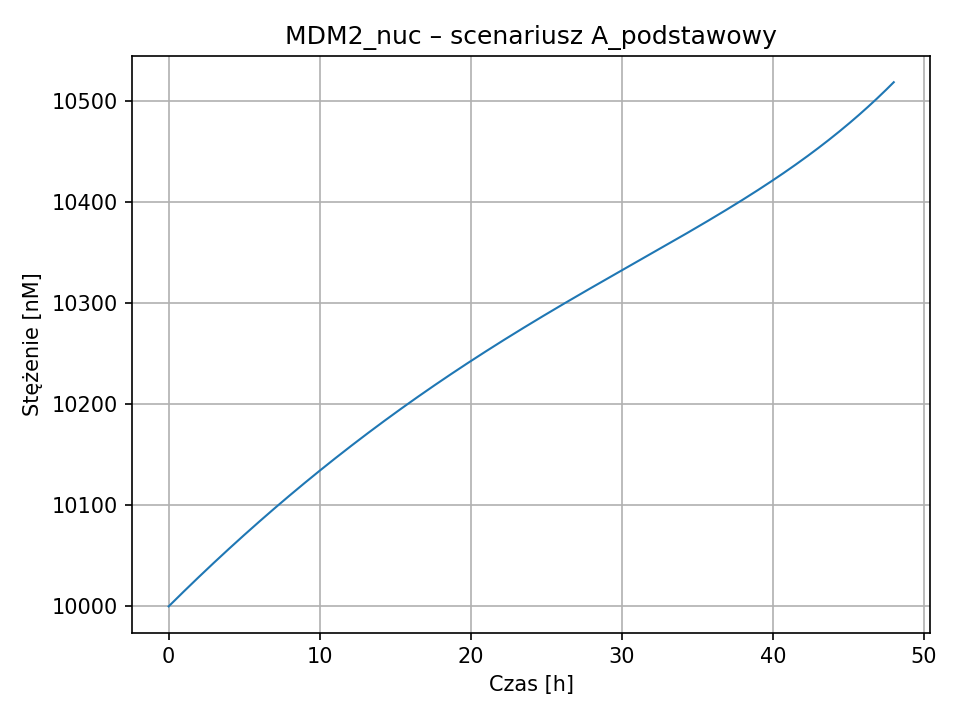
## P53
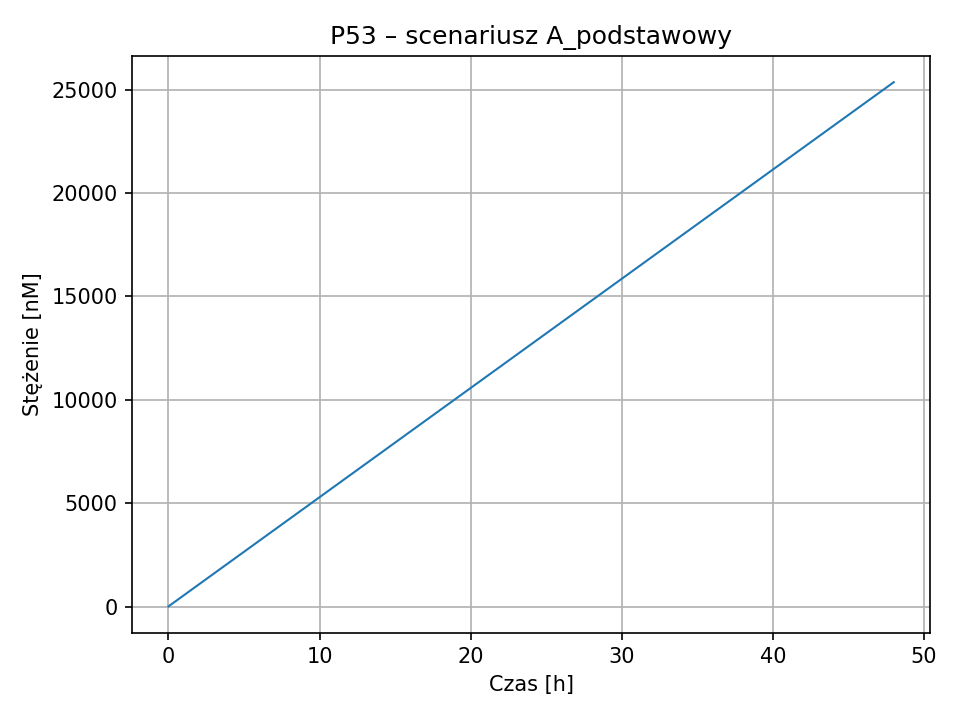
## PTEN
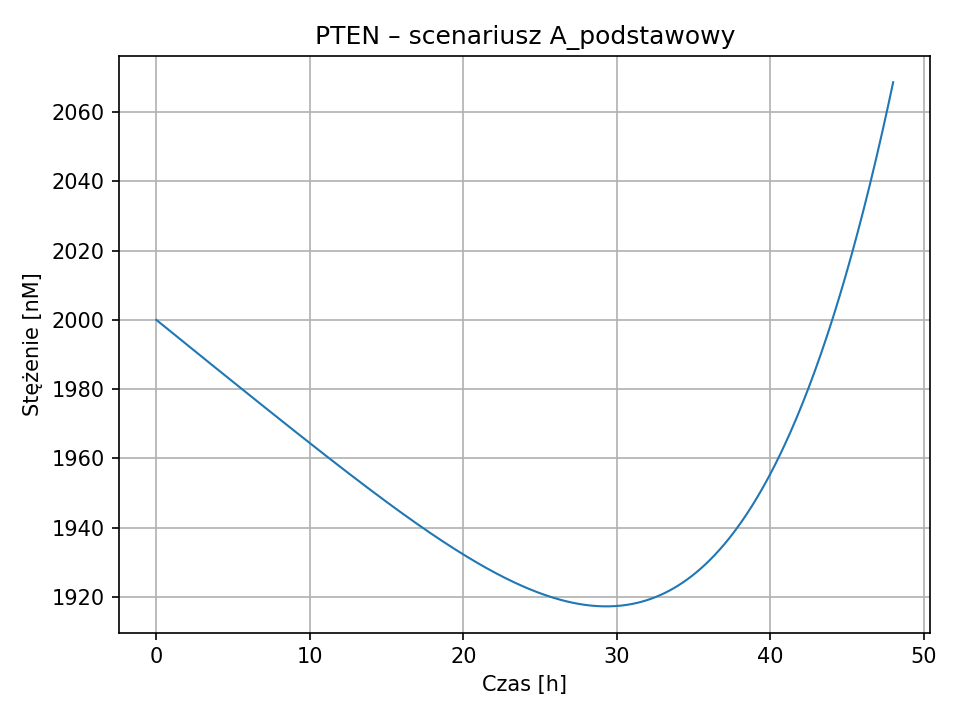

## Scenariusz B
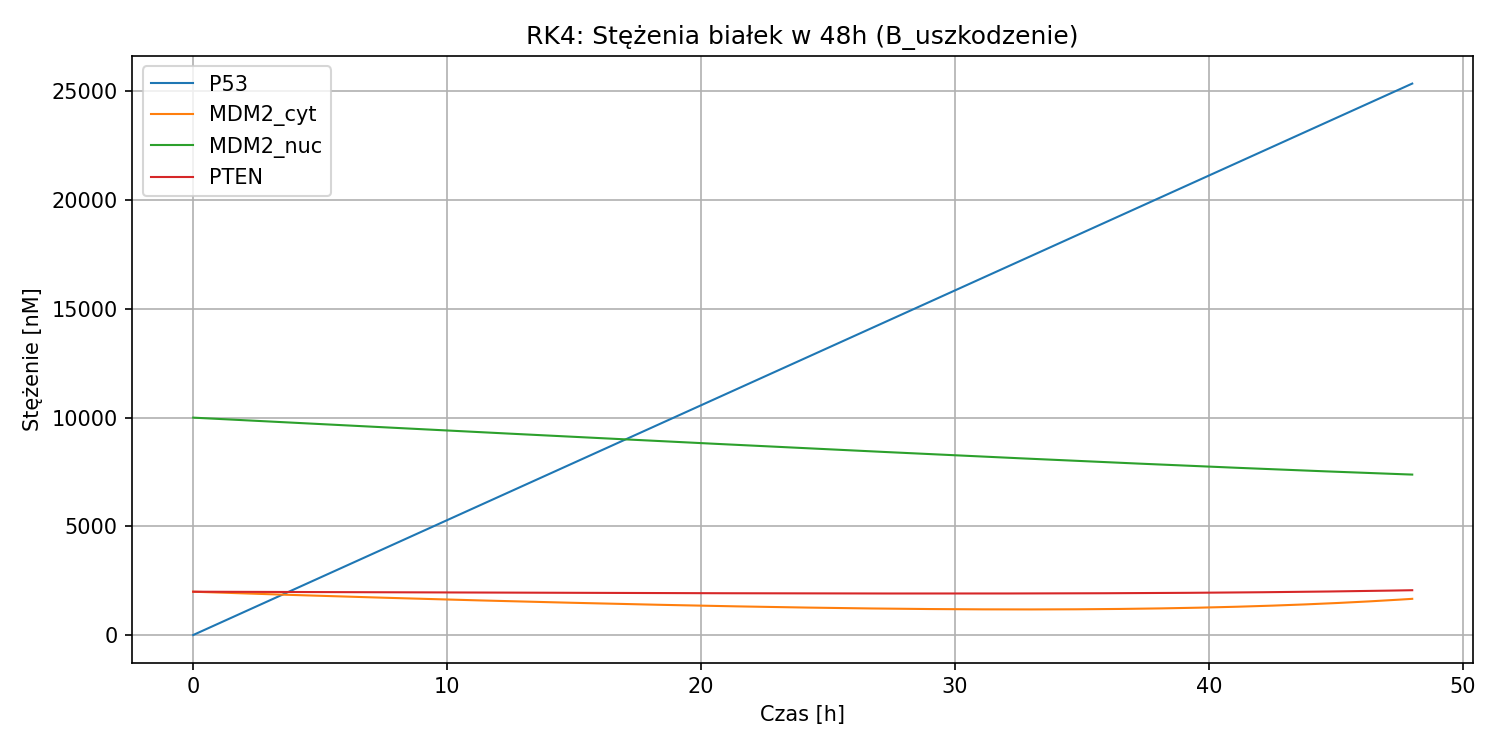
## MDM2_cyt
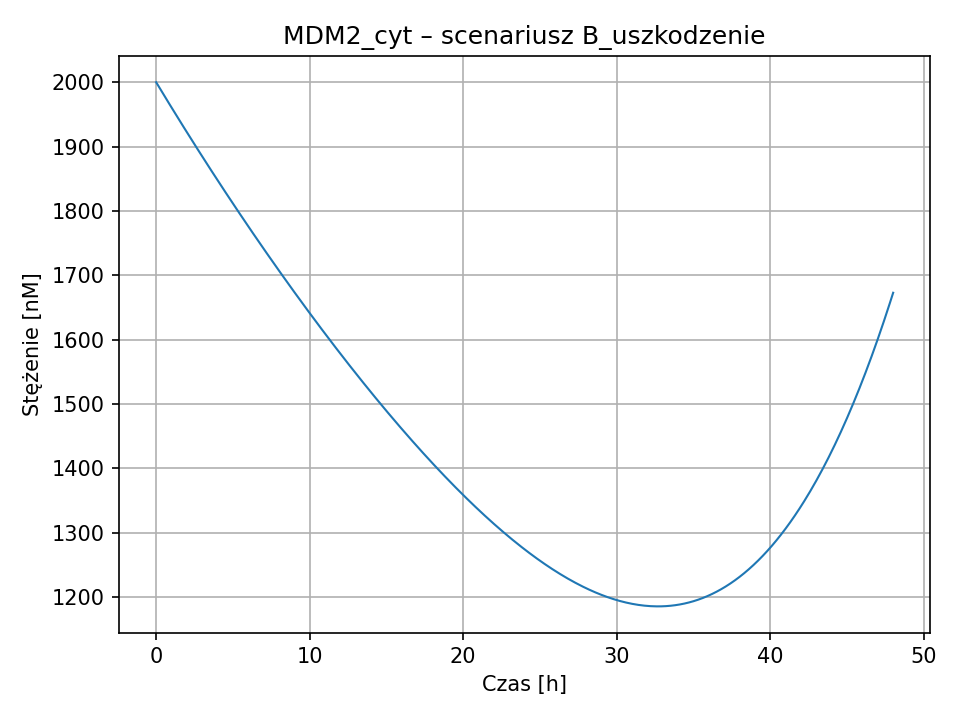
## MDM2_nuc
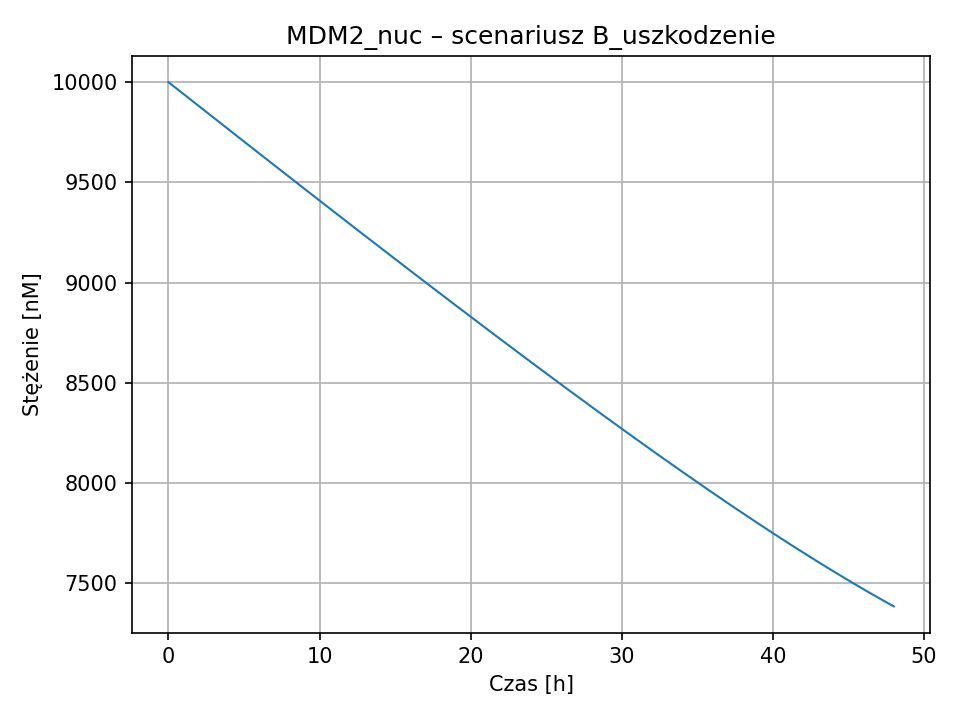
## P53
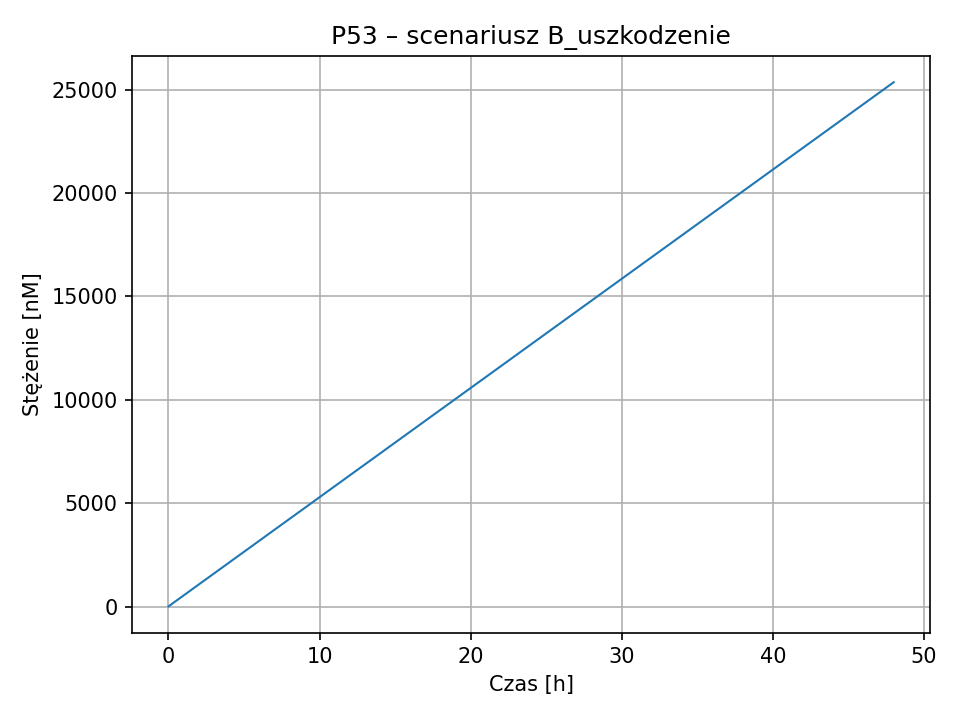
## PTEN
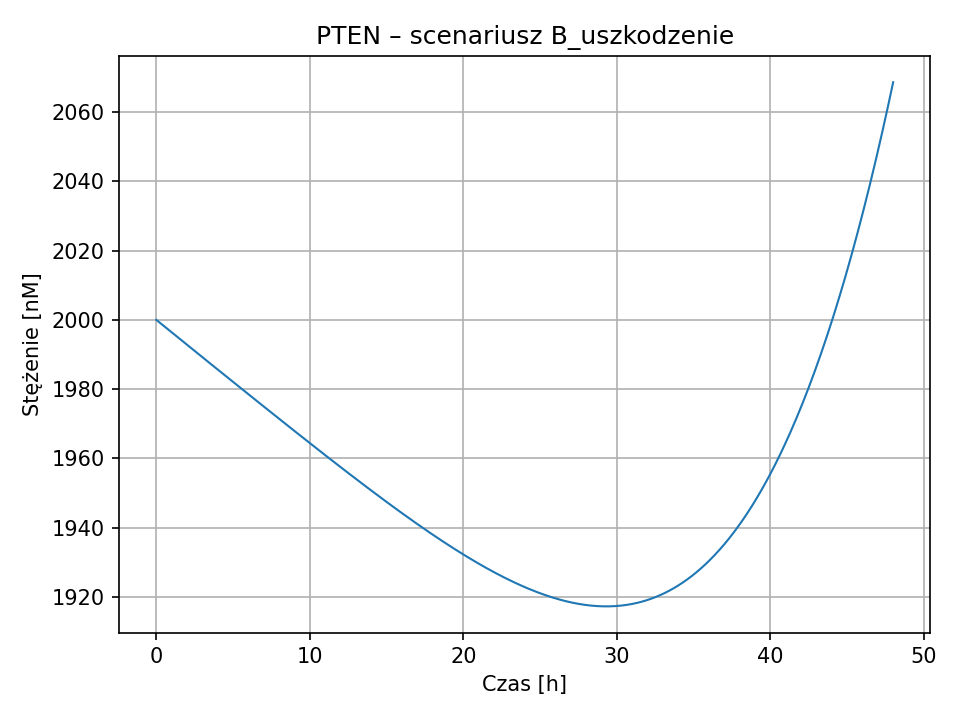

## Scenariusz C
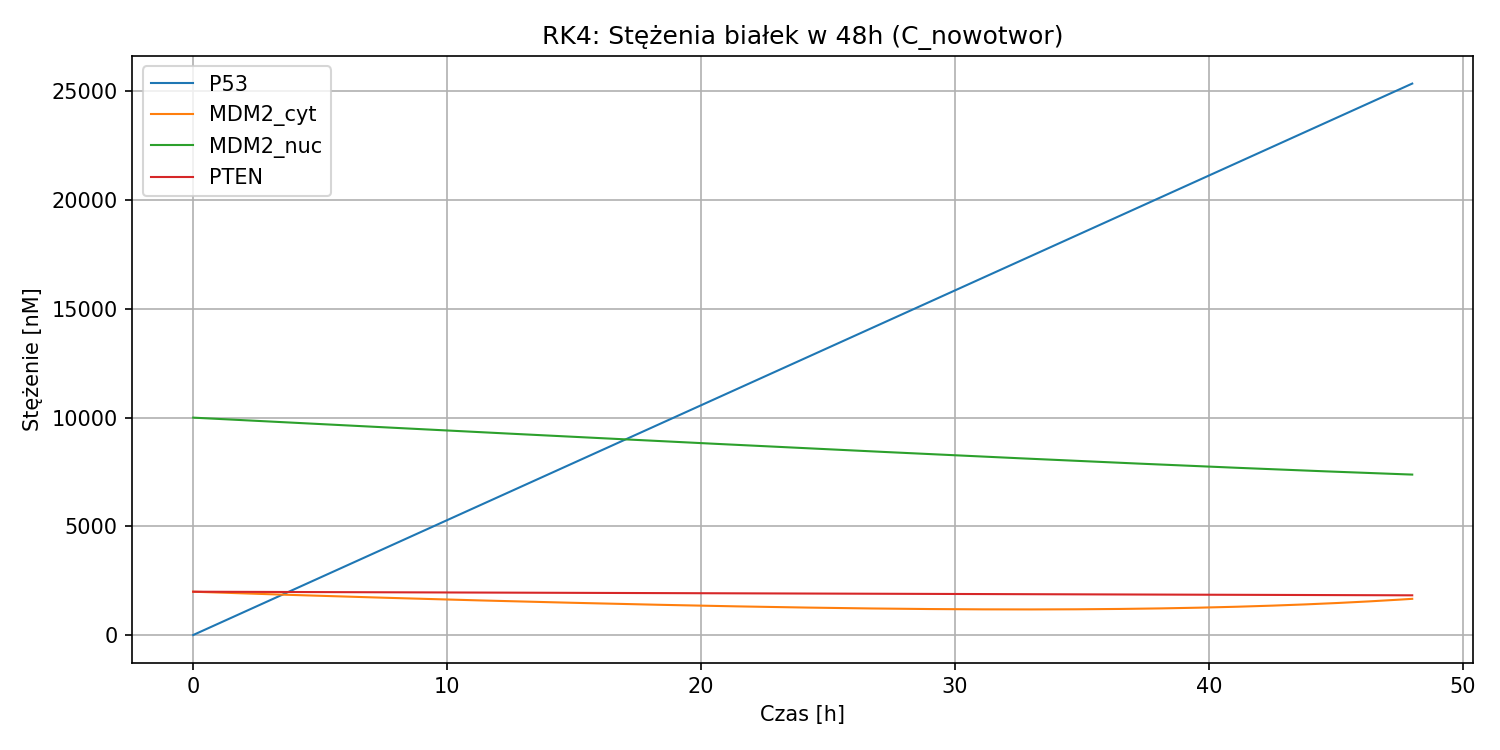
## MDM2_cyt
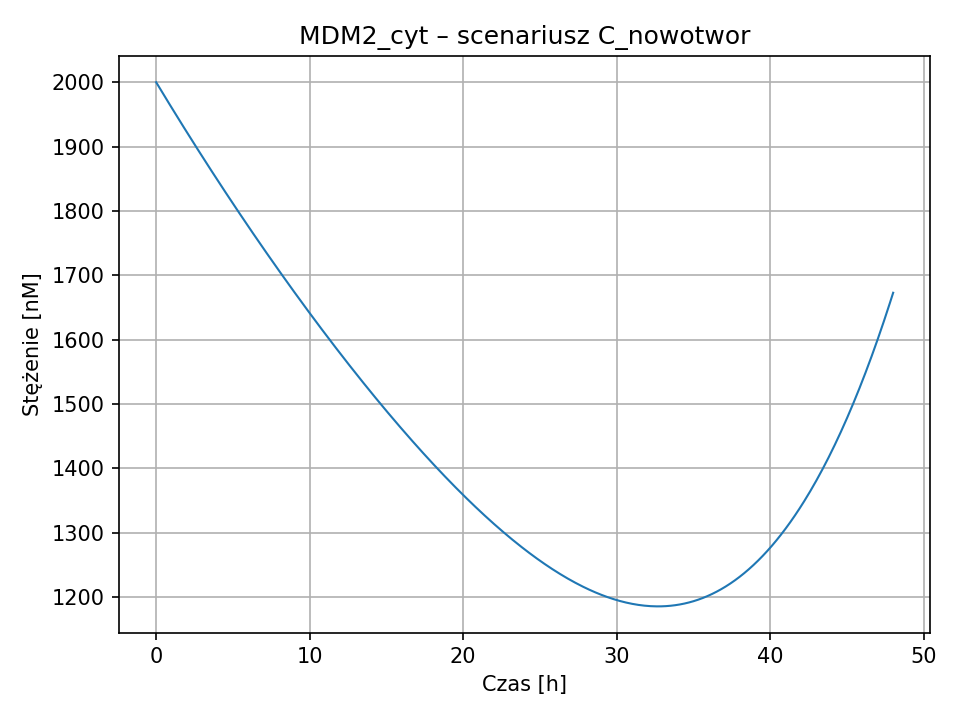
## MDM2_nuc
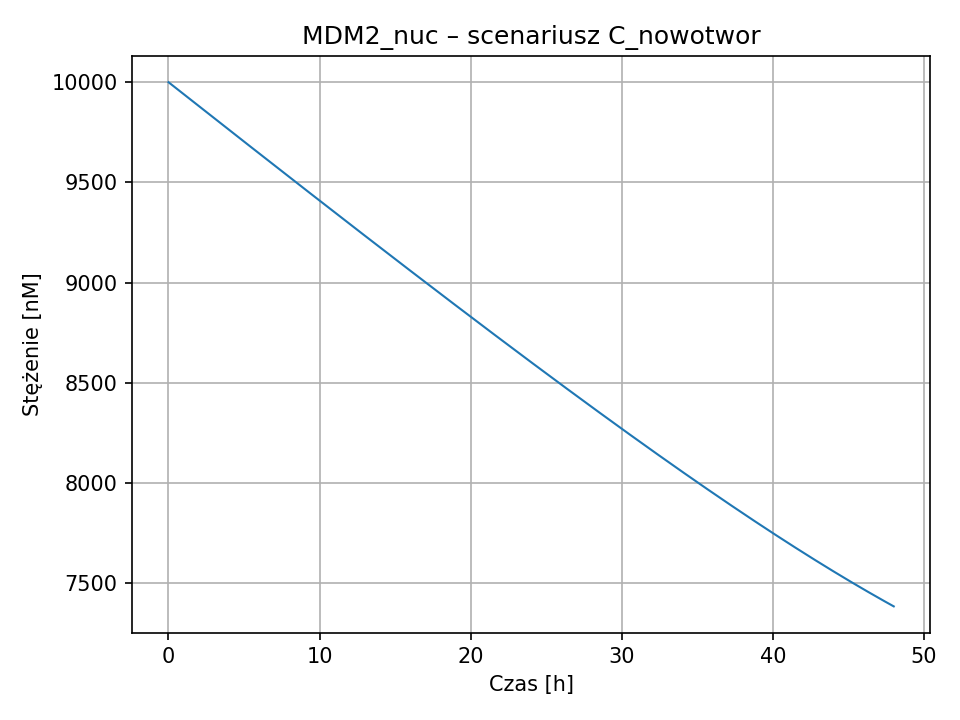
## P53
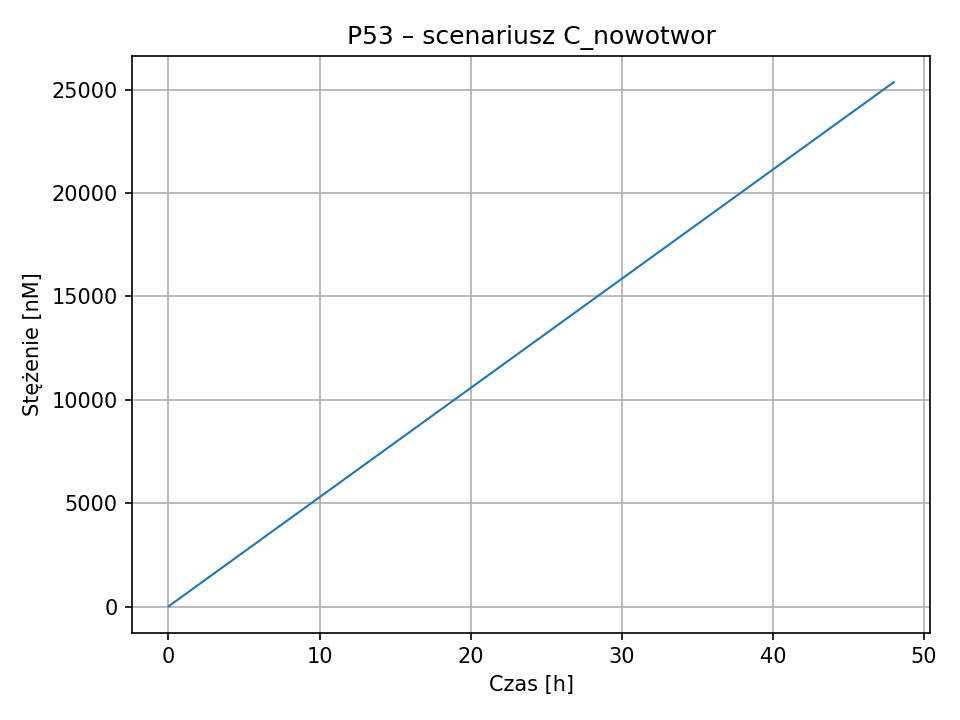
## PTEN
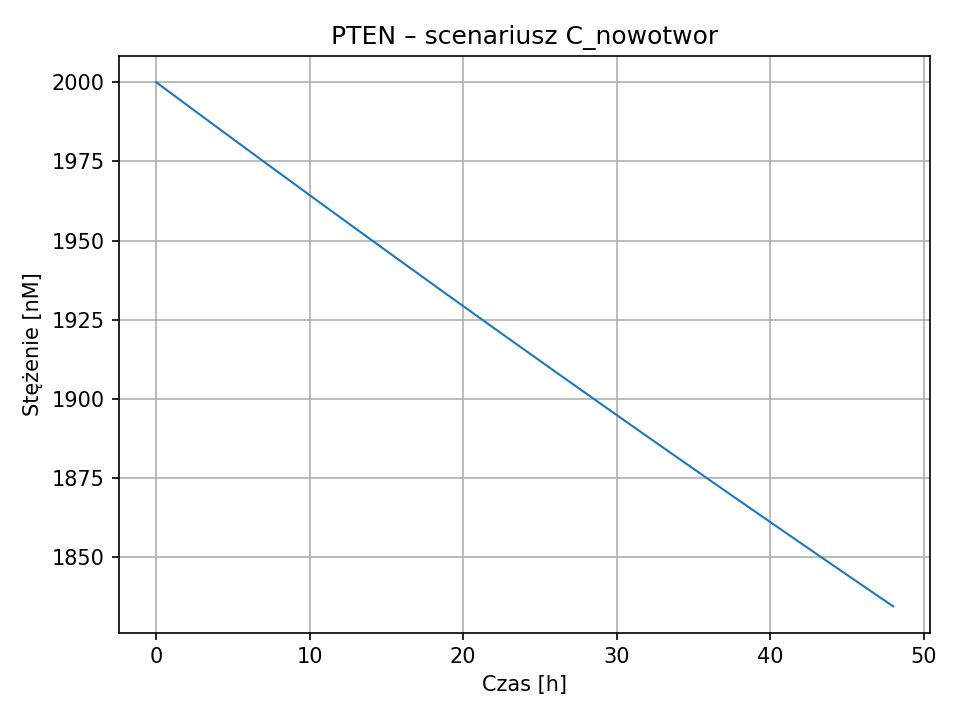

## Scenariusz D
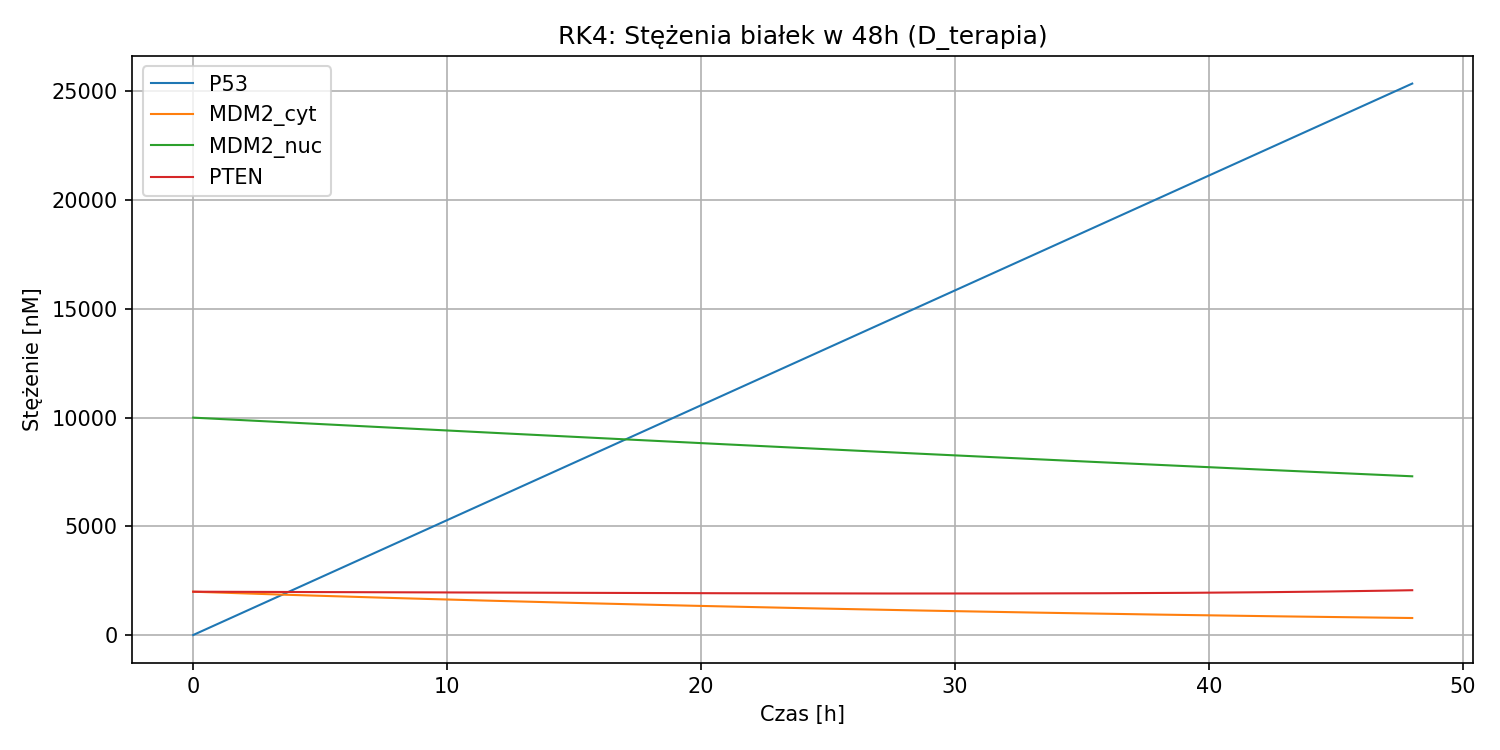
## MDM2_cyt
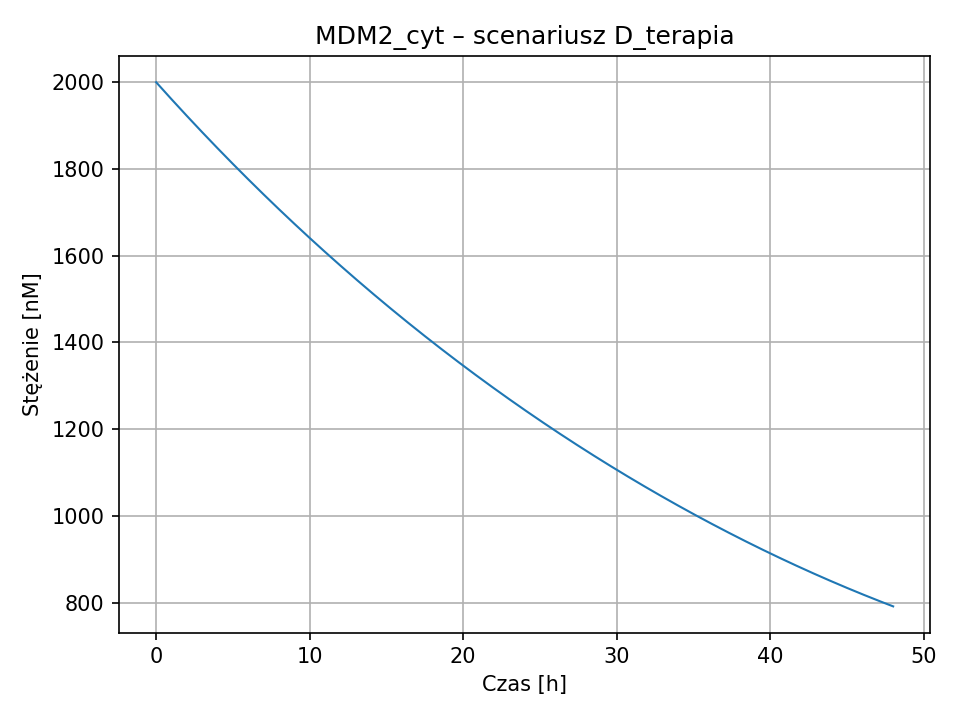
## MDM2_nuc
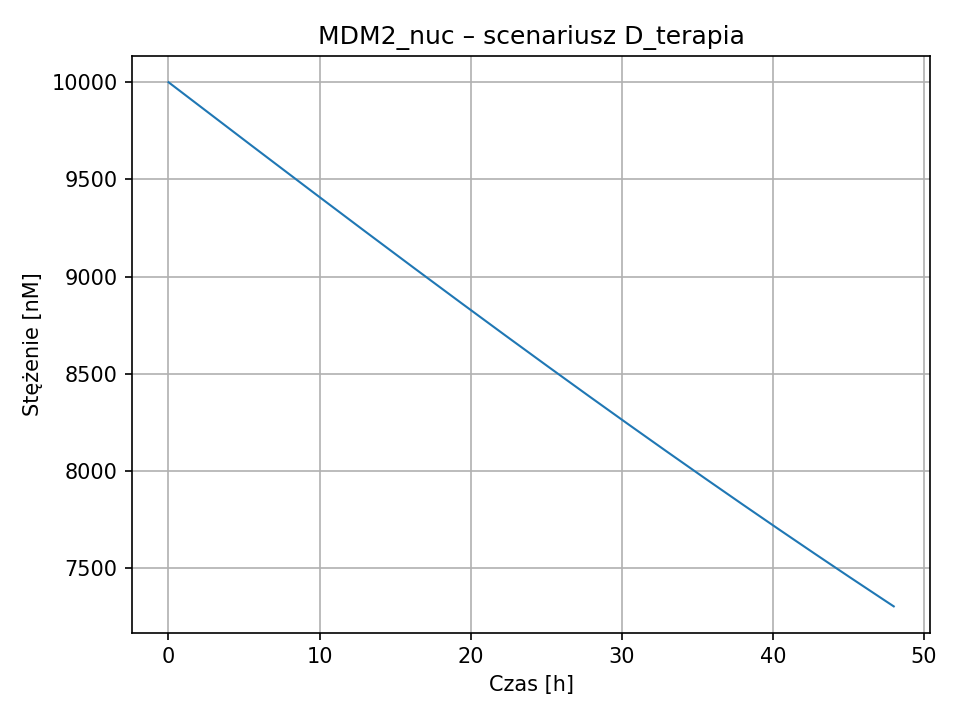
## P53
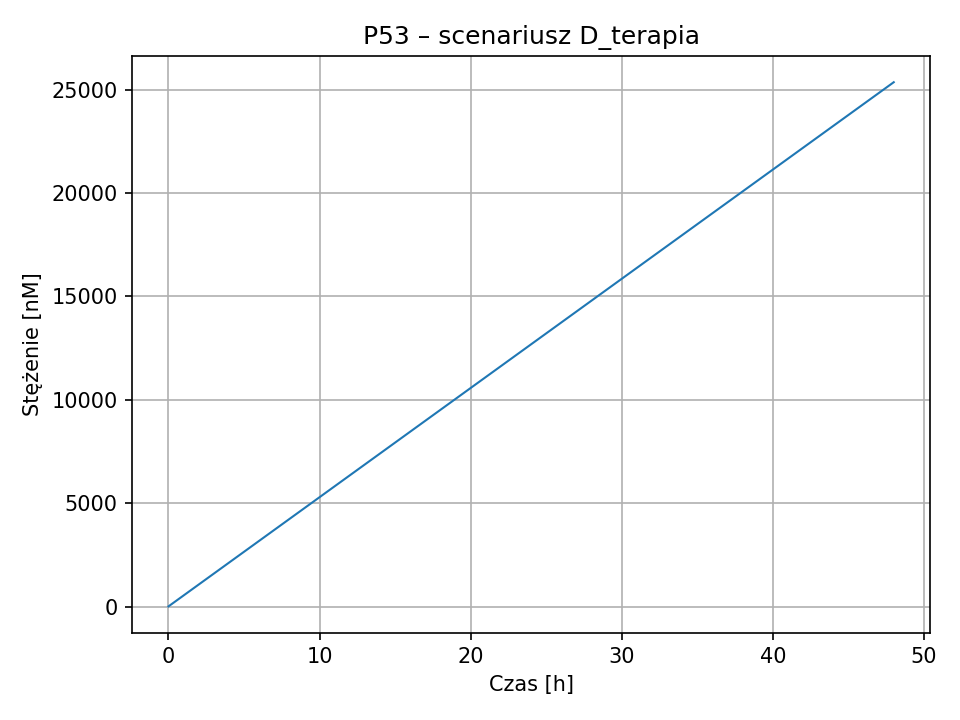
## PTEN
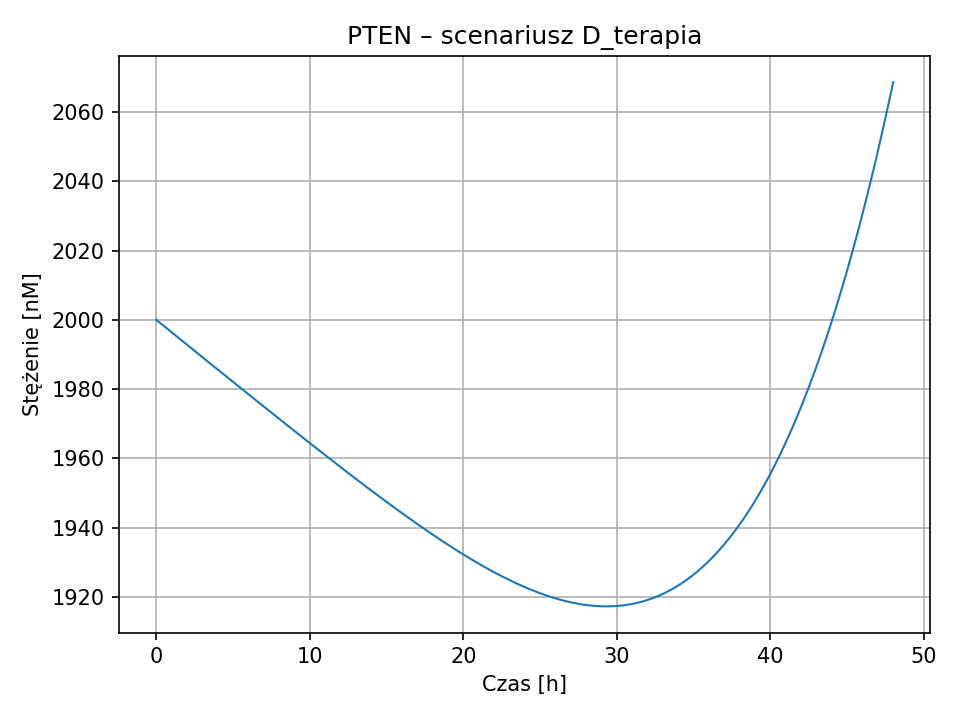
